In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:
# Load the data from L1_8000rpm_data/ folder
X_train = pd.read_csv('8000rpm_data_z-score/train_sample.csv').values
X_test = pd.read_csv('8000rpm_data_z-score/test_sample.csv').values
y_train = pd.read_csv('8000rpm_data_z-score/train_label.csv').values
y_test = pd.read_csv('8000rpm_data_z-score/test_label.csv').values

In [27]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [28]:
# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 254, 128)  # Adjust based on input size
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 9)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [44]:
# Improved CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 126, 512)  # Adjust based on new dimensions
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 9)

    def forward(self, x):
        x = self.batch_norm1(self.relu1(self.conv1(x)))
        x = self.pool1(x)
        x = self.batch_norm2(self.relu2(self.conv2(x)))
        x = self.pool2(x)
        x = self.batch_norm3(self.relu3(self.conv3(x)))
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [54]:
# Instantiate model, loss, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [55]:
# Train the model
num_epochs = 50
history = {'loss': [], 'accuracy': [], 'val_accuracy': []}
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.argmax(dim=1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels.argmax(dim=1)).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_accuracy)
    
    model.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0
    with torch.no_grad():  # No need to compute gradients for validation
        for inputs, labels in test_loader:  # Assuming you have a validation data loader
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels.argmax(dim=1)).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    history['val_accuracy'].append(val_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Loss: 1.4128, Accuracy: 0.3933, Validation Accuracy: 0.6089
Epoch 2/50, Loss: 0.4897, Accuracy: 0.8489, Validation Accuracy: 0.5444
Epoch 3/50, Loss: 0.2037, Accuracy: 0.9611, Validation Accuracy: 0.5978
Epoch 4/50, Loss: 0.0602, Accuracy: 0.9956, Validation Accuracy: 0.5733
Epoch 5/50, Loss: 0.0293, Accuracy: 0.9994, Validation Accuracy: 0.6044
Epoch 6/50, Loss: 0.0156, Accuracy: 0.9994, Validation Accuracy: 0.5778
Epoch 7/50, Loss: 0.0091, Accuracy: 1.0000, Validation Accuracy: 0.6089
Epoch 8/50, Loss: 0.0067, Accuracy: 1.0000, Validation Accuracy: 0.5956
Epoch 9/50, Loss: 0.0048, Accuracy: 1.0000, Validation Accuracy: 0.6067
Epoch 10/50, Loss: 0.0081, Accuracy: 0.9989, Validation Accuracy: 0.5378
Epoch 11/50, Loss: 0.0407, Accuracy: 0.9911, Validation Accuracy: 0.6156
Epoch 12/50, Loss: 0.0080, Accuracy: 1.0000, Validation Accuracy: 0.5844
Epoch 13/50, Loss: 0.0029, Accuracy: 1.0000, Validation Accuracy: 0.5956
Epoch 14/50, Loss: 0.0025, Accuracy: 1.0000, Validation Accu

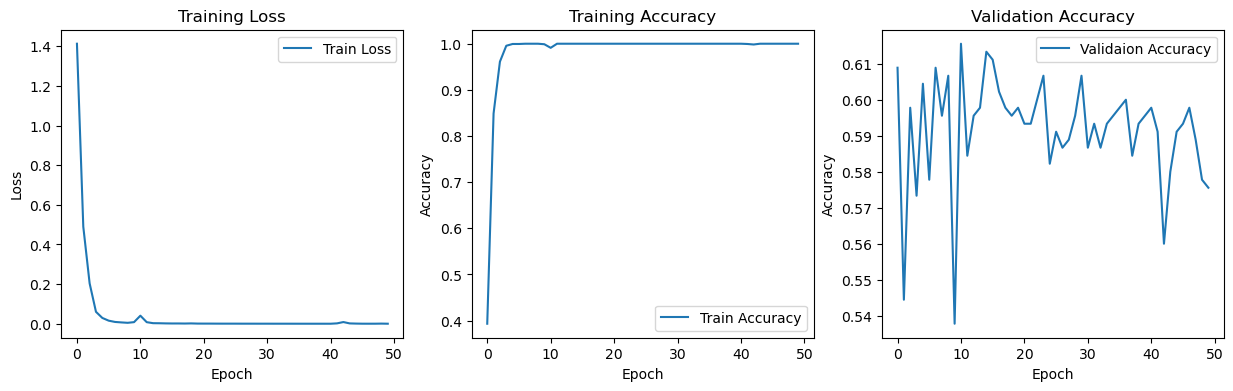

In [56]:
# Plot training loss and accuracy
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')

plt.subplot(1, 3, 3)
plt.plot(history['val_accuracy'], label='Validaion Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.show()

In [33]:
from sklearn.metrics import confusion_matrix

# 模型预测
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 计算混淆矩阵
conf_mat = confusion_matrix(y_test_classes, y_pred_classes)

# 绘制混淆矩阵
plt.matshow(conf_mat, cmap='Blues')
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

AttributeError: 'CNN' object has no attribute 'predict'